# This Notebook contains code to make Main text Figure 2a and Supplemental Figure 5

## Load MatLab File using SciPy

In [1]:
import sklearn as sklearn
import numpy as np                #for numerical operations
import pandas as pd               #for data reading/structure
import matplotlib.pyplot as plt          #Used for plotting
from scipy.optimize import curve_fit
import scipy.signal as signal
from functools import partial
import multiprocessing
from contextlib import contextmanager
import sys
from matplotlib.lines import Line2D
import copy 


from sklearn.decomposition import PCA, NMF, DictionaryLearning
import seaborn as sns
import matplotlib.gridspec as gridspec

import matplotlib.colors
from matplotlib.ticker import StrMethodFormatter

from sklearn.cluster import KMeans

from os.path import dirname, join as pjoin
import scipy.io as sio

#####Define some global Plotting Parameters
plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 1.15
plt.rcParams['lines.linewidth'] = 1.0
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 'small'
plt.rcParams['xtick.labelsize'] = 'small'
plt.rcParams['xtick.major.size'] = 2.5
plt.rcParams['ytick.major.size'] = 2.5
%matplotlib notebook

In [2]:
####Load table from textfile
read=pd.read_table('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\SHOcoefreadvec.txt',names=["Amp",'Res','Q','Phase'])
write=pd.read_table('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\SHOcoefwritevec.txt',names=["Amp",'Res','Q','Phase'])
###Load Mat file to extract DC bias vector

mat_data = sio.loadmat('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\PZTbatch212BEPS_0003.mat',squeeze_me=True, struct_as_record=False)

dc=list(mat_data['dc_amp_vec_full']) ##### DC Bias Values 

In [3]:
num_acq=np.arange(0,900)    ######900 acqusisitions. Collection order is row ordered
acq=np.tile(num_acq,192)
len(acq)

cycle=np.arange(0,3) ########### Cycle number. First 900 acquistion is cycle1 for first DC value. Second 900 for cycle2
# for first DC values
cycle=np.repeat(cycle,900)
cycle=np.tile(cycle,64)
len(cycle)

dc=dc[0:64]        ######### DC Bias Values associated with a single cycle

def reshape_data(df):

#### Create inital index object for the Dataframe. Using .from_product() interate the index to reflect the organization
#of the raw data:The first 30 rows of the array correspond to the SHO coefficients for the first step of the first 
#loop and for the 30 x coordinates along the first y coordinate i.e. SHOcoef(:,1,1,1,1). Then the next 30 rows would 
#be the first step of the first loop for 30 x coordinates along the 2nd y coordinate i.e. SHOcoef(:,2,1,1,1).  
    x_cord=np.array(range(30))
    y_cord=np.array(range(30))
    chirps=np.array(range(192))
    parameters=[chirps,x_cord,y_cord,]  
    index=pd.MultiIndex.from_product(parameters, names=['chirps','y', 'x',])
    df=df.set_index(index)

##### Add Index and Reorganize such that aqusition pionts are along axis=0 (rows) and chirps are along axis=1 columns
    df=df.assign(cycle=cycle).set_index('cycle', append=True)  ####Add Cycle # label
    df=df.unstack(level=3).unstack(level=0).dropna(axis=1,how='all') ####Data Resort by Cycle Number and DC chirps. Original data 
##is grouped by DC step values: every 900 values is the response of every point for the first DC step and cycle. 
##The next 900 is all reponses to the first DC step in the next cycle. The data is ordered corecctly at this line but
## the chirp number labels now longer make sense


####Convert labels from XY coridinate pairs to acquisition numbers
    df=df.set_index(num_acq,)
    df.index.name='Acq#'  

###Create Dictionary to Map chirp labels Bias values. 
    chirp_keys=chirps
    chirp_values=np.repeat(dc,3)
    bias_dict = {chirp_keys[i]: chirp_values[i] for i in range(len(chirp_keys))}   ###Create Dictionary to Map chirp labels Bias values

#### Use dictionary to create new array for indexing
    order1=df.columns.get_level_values('chirps')
    bias=[]
    for i in order1:
        bias.append(bias_dict[i])
    bias=np.array(bias)

##### Get other label arrays from existing data frame. Cycles and Variable Labels were not effected by reordering 
    cycles=df.columns.get_level_values('cycle')
    var=df.columns.get_level_values(None)

### Create a new Multiindex for with relevent Variable, Cycle, Chirp Number, NAd DC bias labels
    col_index=pd.MultiIndex.from_arrays([var,cycles,np.tile(chirps,4),bias], names=['Variable','cycle#','chirp#', 'DC',])


### Put data into new Dataframe with accruate index and column information
    df=pd.DataFrame(df.values, index=df.index, columns=col_index)

#### Calculate PR response from SHO coefficients
    pr= pd.DataFrame(index=df.index,columns=df['Amp'].columns)
    pr=df['Amp']*np.sin(df['Phase'])

#### Add PR to Refit data frame
    df=pd.concat(dict(Amp = df['Amp'], Phase = df['Phase'], Res=df['Res']/1000, Q=df['Q'],PR=pr),axis=1)


###Adjust the phase to make phase lie between 0 and pi
    offset=-1.55
    df['Phase']=df['Phase']+np.abs(offset)
##Convert phase to degrees
    df['Phase']=df['Phase']*(180/np.pi)
    return df



def remove_q(df):
####### Map and Remove points the Data set with Q values larger than 500 and less than 0
    test = df['Q'].applymap(lambda x: np.nan if x< 0 else x)
    test = test.applymap(lambda x: np.nan if x> 500 or x == 500 else x)
    
 ######Make a copy of the input df   
    df_nan=df.copy()

#####
    for var in ['Amp','Phase',"PR",'Res','Q']:
        df_var=df[var].copy()                       ####Create a copy of the variable/parameter dataframe
        df_var[test.isnull()]=np.nan                ####Use test df as mask and assign variable dataframe nan value in same locations
        df_nan[var]=df_var                         ###Replace master dataframe value with masked value (includes nan)

    return df_nan

######function to replace Nans in one vata drame with the values of another
def replace(df1,df2):                         
    df1=pd.DataFrame(df1.values)
    df2=pd.DataFrame(df2.values)  ####Create a copy of the variable/parameter dataframe
    df1=df1.combine_first(df2).fillna(method='backfill',axis=1).fillna(method='ffill',axis=1)####Use test df as mask 
    #and assign variable dataframe nan value in same locations
    return df1



def impute_fill(df,mean,std):
########Define Bounds###########
    mean=mean ### use df_means
    std=std ### use df_devs
        
    upper=mean + (3*std)
    lower=mean - (3*std)
    print('Upper Limit: ', upper)
    print('Lower Limit: ', lower)

######Make a copy of the input df   
    df_fill=df.copy()

####### Map and Remove points the Data set with Q values larger than upper and less than lower
    test = df['Q'].applymap(lambda x: np.nan if x < lower else x)
    test = test.applymap(lambda x: np.nan if x > upper else x)

    for var in ['Amp','Phase',"PR",'Res','Q']:
        df_var=df[var].copy()                       ####Create a copy of the variable/parameter dataframe
        df_var[test.isnull()]=np.nan                ####Use test df as mask and assign variable dataframe nan value in same locations
        df_fill[var]=df_var                         ###Replace master dataframe value with masked value (includes nan)

        df_fill[var]=df_fill[var].interpolate(method='linear',limit=2 ,limit_direction='forward',limit_area='inside', axis=1)
        df_fill[var]=df_fill[var].fillna(method='backfill',axis='columns')     #Axis = columns to back fill from the next DC bias in the waveform at the same point
        df_fill[var]=df_fill[var].fillna(method='ffill',axis='columns') ###forward fill to get the last chirps
        
    return df_fill

##Make a Dictionary of Mean and Standard Deviation Values 
def scales_dict(df):
    var_list=['Amp','Phase','PR','Res','Q']
    means=[df['Amp'].mean(skipna=True).mean(skipna=True),df['Phase'].mean(skipna=True).mean(skipna=True),df['PR'].mean(skipna=True).mean(skipna=True),df['Res'].mean(skipna=True).mean(skipna=True),df['Q'].mean(skipna=True).mean(skipna=True)]
    means_dict={var_list[i]: means[i] for i in range(len(var_list))} 
    devs=[df['Amp'].std(skipna=True).mean(skipna=True),df['Phase'].std(skipna=True).mean(skipna=True),df['PR'].std(skipna=True).mean(skipna=True),df['Res'].std(skipna=True).mean(skipna=True),df['Q'].std(skipna=True).mean(skipna=True)]
    std_dict={var_list[i]: devs[i] for i in range(len(var_list))} 

    return means_dict,std_dict

In [4]:
###Re-order data,
write=reshape_data(write)
read=reshape_data(read)

###get means standard deviations
read_means,read_devs=scales_dict(read)
write_means,write_devs=scales_dict(write)
read_means['Amp']

####remove chirps associated with "bad" q values and fill missing data
write_nan=remove_q(write)   
read_nan=remove_q(read)

##Filter by Q limits (values of q more than 3 standard deviation from the mean)
write_1=impute_fill(write_nan,mean=write_means['Q'],std=write_devs['Q'])
read_1=impute_fill(read_nan,mean=read_means['Q'],std=read_devs['Q'])

###Remove first four inital chirps from cycle 0
read_1.drop([0,1,2,3],axis=1,level="chirp#",inplace=True)
read_nan.drop([0,1,2,3],axis=1,level="chirp#",inplace=True)
write_1.drop([0,1,2,3],axis=1,level="chirp#",inplace=True)
write_nan.drop([0,1,2,3],axis=1,level="chirp#",inplace=True)

#######Run Again to get new scaling values for later dimensional reduction
read_means,read_devs=scales_dict(read_1)           
write_means,write_devs=scales_dict(write_1)
read_means['Res']

Upper Limit:  420.2031366496445
Lower Limit:  91.54938337259222
Upper Limit:  463.6871987264025
Lower Limit:  59.05405613017291


330.9834718019076

### PCA Denoising

In [5]:
#####Create loops avaraged across cycles 2 and 3 for PCA and K-means approach
### Replace missing data in one cycle with valid vlaues of the other
off_1=replace(read_nan["PR"][2],read_nan["PR"][1])
off_2=replace(read_nan["PR"][1],read_nan["PR"][2])

on_1=replace(write_nan["PR"][2],write_nan["PR"][1])
on_2=replace(write_nan["PR"][1],write_nan["PR"][2])

#####Avarage the cycle 2 and cycle 3 loops 
ave_off=pd.DataFrame((off_1.values+off_2.values)/2, columns=read_nan["Amp"][1].columns)
ave_on=pd.DataFrame((on_1.values+on_2.values)/2, columns=read_nan["Amp"][1].columns)

In [9]:
#Some Checks
df= ave_on
#print(np.shape(df["Q"]))
print(np.where(df.isnull()))  #### machine learning cannot have Nan or Inf values
#print(np.where(df['Q']>500)) ##### chirps due to poor SHO fits are gone
#print(np.where(df['Q']<5))


(array([], dtype=int64), array([], dtype=int64))


In [13]:
### Data Preprocessing for Analysis
def z_prep(df):
#####Remove Means and Standardize by Standard Deviation
    df=df.sub(df.mean(axis=1, skipna=True), axis=0) #### axis =1 to look across pionts in space (rows) to correct for drift in resonance values during measurement, skipna =True to skip NaN values    
######z-standardization
    mean_val = df.mean().mean()             #### will already be zero from proceeding step
    std_val = df.std().mean()
    df=df.sub(mean_val)/std_val ########center at zero
    return df

In [14]:
ave_off=z_prep(ave_off)
ave_on=z_prep(ave_on)
print('Mean: ',round(ave_off.mean().mean(),3))
print('Dev: ',round(ave_off.std().mean(),3))
print('Mean: ',round(ave_on.mean().mean(),3))
print('Dev: ',round(ave_on.std().mean(),3))

Mean:  -0.0
Dev:  1.0
Mean:  0.0
Dev:  1.0


#### Supplementary Figure 7

<IPython.core.display.Javascript object>


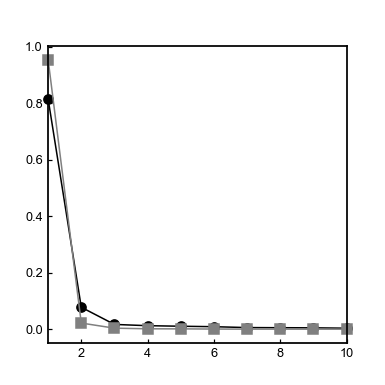

In [15]:
#####PCA Denoising

####calculate the covariance matrix
pca = PCA(n_components = 10)

####calculate the eigen values
pca.fit(ave_off)
off_variance = pca.explained_variance_ratio_ #calculate variance ratios
off_var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

pca.fit(ave_on)
on_variance = pca.explained_variance_ratio_ #calculate variance ratios
on_var=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)

fig = plt.figure(figsize=(3.5,3.5))
x=[1,2,3,4,5,6,7,8,9,10]
plt.plot(x,off_variance,marker='o',c='black',clip_on=False)
plt.plot(x,on_variance, marker='s',c='grey', clip_on=False)

ax= plt.gca()
ax.set_xlim([1,10])
ax.set_xticks([2,4,6,8,10])

### Main Text Figure 2A

In [88]:
####Load table from textfile containing the denoised PCA components

PCA_R=pd.read_table('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\off_PCA.txt',names=[0,1,2,3,4,5,6,7,8,9])
PCA_W=pd.read_table('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\on_PCA.txt',names=[0,1,2,3,4,5,6,7,8,9])

def make_data(i):
    Off=PCA_R.loc[:,0:i]    #### i is desired number of PCA components to keep in analysis 
    On=PCA_W.loc[:,0:i]
    data=pd.concat( [Off,On],axis=1,) ###Data Stacking PR from On and Off field Denoised data
    return data

In [89]:
PR0= make_data(0)
PR1= make_data(1)
PR2= make_data(2)
PR3= make_data(3)
PR4= make_data(4)    ###Extract data and stack on and off field behvaiors

In [90]:
PR4.iloc[:,5]    #Stacked object for K-means analysis 

,0,1,2,3,4,0,1,2,3,4
0,-0.020670,0.008795,0.003905,0.011912,0.001141,-0.046066,0.006300,-0.051554,0.018998,-0.004781
1,-0.046866,0.020461,0.009133,0.004922,0.026941,-0.020734,0.027549,0.060410,-0.006736,0.021129
2,-0.019348,0.052756,-0.064266,-0.025810,-0.054421,0.003821,0.032323,0.021156,0.064692,-0.063583
3,-0.017415,0.004013,0.011094,0.016363,-0.019016,-0.040622,0.006537,-0.045169,0.021651,-0.001470
4,-0.018639,0.000779,0.024232,0.005259,-0.028169,-0.036880,0.008973,-0.032274,0.009858,0.001552
...,...,...,...,...,...,...,...,...,...,...
895,-0.038683,0.014851,-0.002176,-0.005001,0.006458,-0.022768,0.023912,0.039074,-0.001877,0.016930
896,-0.030398,0.007160,0.016851,0.014283,0.009897,-0.041463,0.013953,-0.013437,0.004472,0.008283
897,-0.017814,0.003464,0.015011,-0.003000,-0.024412,-0.037804,0.007516,-0.039762,0.009973,-0.003994
898,-0.027445,0.005248,0.022401,0.011857,-0.013809,-0.039739,0.013432,-0.014926,-0.008962,0.001182


<IPython.core.display.Javascript object>


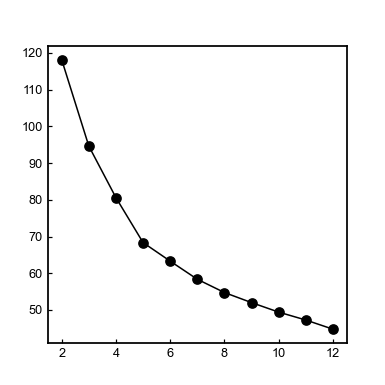

In [91]:
#####Scree for determination of number of clusters as shown in main text Figure 2a
def plot_scree(data,ax, label):
    test = data/data.max().max()
    wcss = []
    for i in range(2, 13):
        kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
        kmeans.fit(test)
        wcss.append(kmeans.inertia_)
    wcss_max=np.max(wcss)
    ax.plot(range(2, 13), wcss,color ='black',marker='o', label=label)
    #ax.set_xlabel(' ')
    #ax.set_ylabel(' ')
    #plt.legend()

#Plot the scree
fig = plt.figure(figsize=(3.5,3.5))
ax = plt.gca()
#plot_scree(PR0,ax,'1 PCA')
#plot_scree(PR1,ax,'2 PCA')
#plot_scree(PR2,ax,'3 PCA')
#plot_scree(PR3,ax,'4 PCA')
plot_scree(PR4,ax,'5 PCA')
#ax.set_xticklabels([])

#ax.set_yticks([0.4,0.6,0.8,1.0])
#ax.set_yticklabels([])

In [27]:
plt.savefig('C:\\Users\\keris\\Dropbox (GaTech)\ME-DboxMgmt-Bassiri-Gharb\\K_Williams\\2020\\BEPS PTP Data\\Writing\\ISAF\\Figures\\K-means_Scree.png',dpi=500,bbox_inches = 'tight',
    pad_inches = 0.05)